In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# Step 0: Extract the point cloud data from the OBJ files
 - store as numpy arrays

In [2]:
# Getting the path to the Raw point clouds

OBJ_DIR = 'point_clouds/'

# Format is a tuple of (file path, file name).
OBJ_PATHS = [ [os.path.join(OBJ_DIR, f), f]
                    for f in os.listdir(OBJ_DIR) ]

OBJ_PATHS.remove(OBJ_PATHS[1]) # remove .DS Store file

# If we desire to treat the various objects within the OBJ as different spaces,
# we store it here.
new_per_object_collection = []

# If we desire to treat the entire OBJ as a space,
# we store it here.
new_per_space_collection = []

# This is to combine the objects within an OBJ to slightly larger objects. 
#Roughly 2.5m radius
combining_radius = 2.5

for path, filename in OBJ_PATHS:
    
    pointCloudFile = open(path)#'point_cloud.obj')('SpatialMesh.obj')#

    pointCloudLines = pointCloudFile.readlines()
    
    pointCollection = [] # object_number, vertices, vertex normals, polygons

    pointCollection_no_objects = [[],[],[]] 
    prev_length = 0
    vertices_length = 1
    
    for line in pointCloudLines:

        if line == '\n': continue

        line_items = line.split()

        if line_items[0] == 'o':
            object_item = line_items[1].split('.')
            object_number = int(object_item[-1])
            pointCollection.append([object_number, [], [], []])
            vertices_length += prev_length

            #print(object_number)

        if line_items[0] == 'v':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            if len(line_items)> 4:
                c = line_items[4]
                if float(c) > 0.85:
                    pointCollection[object_number-1][1].append([float(x),float(y),float(z),float(c)])
                    pointCollection_no_objects[0].append([float(x),float(y),float(z),float(c)])
            else:
                pointCollection[object_number-1][1].append([float(x),float(y),float(z)])
                pointCollection_no_objects[0].append([float(x),float(y),float(z)])
            prev_length = len(pointCollection[object_number-1][1])


        if line_items[0] == 'vn':
            x = line_items[1]
            y = line_items[2]
            z = line_items[3]
            pointCollection[object_number-1][2].append([float(x),float(y),float(z)])
            pointCollection_no_objects[1].append([float(x),float(y),float(z)])

        if line_items[0] == 'f':
            p1 = int(line_items[1].split('//')[0])
            p2 = int(line_items[2].split('//')[0])
            p3 = int(line_items[3].split('//')[0])
            pointCollection[object_number-1][3].append([p1-vertices_length,
                                                        p2-vertices_length,
                                                        p3-vertices_length])
            pointCollection_no_objects[2].append([p1-1,p2-1,p3-1])        

    pointCloudFile.close
    print(filename)
    #print(" Length of point collection",len(pointCollection[1][1]))
    print(" Total number of point collections",len(pointCollection))
    
    #Combining objects: 1. Getting centroids
    centroids = []

    for object_name, pointCloud, _vn, triangles in pointCollection:
        pointCloud = np.asarray(pointCloud)
        triangles = np.asarray(triangles)#-vertices_length
        normals = np.asarray(_vn)
        
        centroids.append([object_name,
              np.mean(pointCloud[:,0]), # x-axis
              np.mean(pointCloud[:,2]), # z-axis
             ])
        
    centroids = np.asarray(centroids)
    remaining_centroids = np.copy(centroids)
    
    combinedPointCollection = []
    count = 1
    
    while(remaining_centroids.size!=0):
        #print("  ",remaining_centroids[0,0],remaining_centroids.shape)
        #focusing on the first remaining collection, i.e. through its centroid
        collection = np.where(LA.norm(remaining_centroids[:,1:] - remaining_centroids[0,1:], axis = 1)<combining_radius)[0]
        
        #print("  ",collection)
        
        pointCloud = np.asarray(pointCollection[int(remaining_centroids[collection[0],0]-1)][1])
        normals = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][2])
        triangles = np.asarray(pointCollection[int(remaining_centroids[collection[0],0])-1][3])

        for index in collection[1:]:
            
            n_pointCloud = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][1])
            n_normals = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][2])
            n_triangles = np.asarray(pointCollection[int(remaining_centroids[index,0])-1][3])+len(pointCloud)

            pointCloud = np.concatenate((pointCloud,n_pointCloud),0)
            normals = np.concatenate((normals,n_normals),0)
            triangles = np.concatenate((triangles,n_triangles),0)
        
        new_per_object_collection.append([
            filename+str(count),
            pointCloud,
            normals,
            triangles])
        
        combinedPointCollection.append([
            pointCloud,
            normals,
            triangles])
            
        count += 1
        remaining_centroids = np.delete(remaining_centroids,collection,axis=0)
        #print("   post",remaining_centroids.shape)
        
    print(" Resulting number =",len(combinedPointCollection))
#    new_per_object_collection.append([
#        filename,
#        combinedPointCollection
#    ])
    
    new_per_space_collection.append([
        filename,
        np.asarray(pointCollection_no_objects[0]),
        np.asarray(pointCollection_no_objects[1]),
        np.asarray(pointCollection_no_objects[2])
    ])

print(len(new_per_object_collection),"total objects.")
print(len(new_per_space_collection),"total spaces.")

Reception-Data61-L5.obj
 Total number of point collections 37
 Resulting number = 11
Driveway.obj
 Total number of point collections 51
 Resulting number = 11
Apartment.obj
 Total number of point collections 38
 Resulting number = 6
Workstations-Data61-L4.obj
 Total number of point collections 54
 Resulting number = 10
Kitchen-Data61-L4.obj
 Total number of point collections 105
 Resulting number = 18
HallWayToKitchen-Data61-L4.obj
 Total number of point collections 40
 Resulting number = 7
StairWell-Data61-L4.obj
 Total number of point collections 81
 Resulting number = 18
81 total objects.
7 total spaces.


In [3]:
# Combining the point position information with their normal vectors.

new_contiguous_point_collection = []

for object_name, pointCloud, vn, triangles in new_per_space_collection:
    new_contiguous_point_collection.append([
        object_name, 
        np.concatenate((pointCloud,vn),axis = 1),
        triangles
    ])
    
sample_index = np.random.choice(len(new_contiguous_point_collection))
print("Sample:",
      new_contiguous_point_collection[sample_index][0],
      new_contiguous_point_collection[sample_index][1].shape, # shape of the point cloud array
      new_contiguous_point_collection[sample_index][2].shape # shape of the triangle array
     )

with open('point_collection/new_contiguous_point_collection.pickle','wb') as f: 
    pickle.dump(new_contiguous_point_collection,f)

Sample: StairWell-Data61-L4.obj (77903, 6) (129848, 3)


Driveway.obj (56926, 6) (88560, 3)


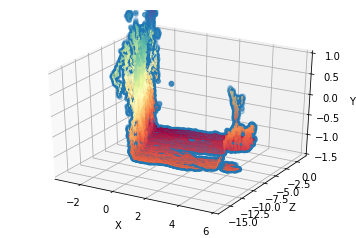

In [33]:
"""
fig=plt.figure()#figsize=(20, 14.5))

sample_name = new_contiguous_point_collection[sample_index][0]
sample_pointCloud = new_contiguous_point_collection[sample_index][1]
sample_triangles = new_contiguous_point_collection[sample_index][2]

print(sample_name,sample_pointCloud.shape,sample_triangles.shape)

ax0 = fig.add_subplot(1,1,1, projection='3d')
ax0.set_xlabel('X')
ax0.set_ylabel('Z')
ax0.set_zlabel('Y')
ax0.set_zlim(-1.5,1)
#ax0.set_title('Dense Point Cloud')

X = sample_pointCloud[:,0]
Y = sample_pointCloud[:,1]
Z = sample_pointCloud[:,2]

ax0.set_xlim(min(X), max(X))
ax0.set_ylim(min(-Z), max(-Z))

try:
    ax0.scatter(
        X,-Z,Y,
        alpha = 0.3
    )

    ax0.plot_trisurf(
        X, -Z, Y, 
        triangles=sample_triangles,
        cmap=plt.cm.Spectral
        #alpha = 0.5
    )

except Exception as ex:
    print(ex)
    pass

#plt.show()
"""

# Step 0.1 Getting the NNs for creating samples for testing

NOTE! This step is only essential for creating sample sapces for testing. There are prepared samples at testing_samples/*. Thus, you may skip this step.

In [13]:
# For better testing, use bigger nn-range. We used 20,000.
nn_range = 300

for object_name, pointCloud, triangles in new_contiguous_point_collection:
    
    t0 = time.time()
    
    print(object_name, np.asarray(pointCloud).shape, np.asarray(triangles).shape)
    
    nbrs = NearestNeighbors(n_neighbors=min(nn_range, len(pointCloud)-1), algorithm='kd_tree').fit(pointCloud[:,:3])
    print("  Done in getting tree {:.3f} seconds.".format(time.time()-t0))

    distances, indices = nbrs.kneighbors(pointCloud[:,:3])

    print("  ",distances.shape,np.mean(np.max(distances,axis=0)), indices.shape)
    
    with h5py.File('hd5/{}_nn.h5'.format(object_name), 'w') as f:
        f.create_dataset('distances', data=distances)
        f.create_dataset('indices', data=indices)

    print("  Done in getting nn {:.3f} seconds.".format(time.time()-t0))

Reception-Data61-L5.obj (40491, 6) (67174, 3)
  Done in getting tree 0.029 seconds.
   (40491, 300) 2.4160527568802825 (40491, 300)
  Done in getting nn 3.349 seconds.
Driveway.obj (56926, 6) (88560, 3)
  Done in getting tree 0.075 seconds.
   (56926, 300) 1.3047040058362143 (56926, 300)
  Done in getting nn 4.582 seconds.
Apartment.obj (72859, 6) (126700, 3)
  Done in getting tree 0.084 seconds.
   (72859, 300) 1.2013160980989808 (72859, 300)
  Done in getting nn 4.811 seconds.
Workstations-Data61-L4.obj (73215, 6) (121972, 3)
  Done in getting tree 0.051 seconds.
   (73215, 300) 1.4038054840864285 (73215, 300)
  Done in getting nn 4.432 seconds.
Kitchen-Data61-L4.obj (102337, 6) (176558, 3)
  Done in getting tree 0.064 seconds.
   (102337, 300) 1.507763636171181 (102337, 300)
  Done in getting nn 6.194 seconds.
HallWayToKitchen-Data61-L4.obj (26398, 6) (44989, 3)
  Done in getting tree 0.025 seconds.
   (26398, 300) 1.6217560940912543 (26398, 300)
  Done in getting nn 1.533 seconds.


In [4]:
"""
    Extracting the NNs we got from the previous step and storing it as a 
    list that we can access to extract partial spaces.
"""
extracted_nns = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
    
    t0 = time.time()
    
    print(object_name, np.asarray(pointCloud).shape, np.asarray(triangles).shape)
    
    extracted_distances = []
    extracted_indices = []
    
    with h5py.File('hd5/{}_nn.h5'.format(object_name), 'r') as f:
        distances = f['distances']
        indices = f['indices']
        
        print("  Done extracting from file in {:.3f} seconds.".format(time.time()-t0))
        
        extracted_distances = np.copy(distances)
        extracted_indices = np.copy(indices)

    print("  ",extracted_distances.shape, extracted_indices.shape)
    
    print("  Done copying in {:.3f} seconds.".format(time.time()-t0))
    
    extracted_nns.append([
        object_name,
        extracted_distances,
        extracted_indices
    ])


Reception-Data61-L5.obj (40491, 6) (67174, 3)
  Done extracting from file in 0.006 seconds.
   (40491, 300) (40491, 300)
  Done copying in 0.302 seconds.
Driveway.obj (56926, 6) (88560, 3)
  Done extracting from file in 0.001 seconds.
   (56926, 300) (56926, 300)
  Done copying in 0.395 seconds.
Apartment.obj (72859, 6) (126700, 3)
  Done extracting from file in 0.003 seconds.
   (72859, 300) (72859, 300)
  Done copying in 0.487 seconds.
Workstations-Data61-L4.obj (73215, 6) (121972, 3)
  Done extracting from file in 0.001 seconds.
   (73215, 300) (73215, 300)
  Done copying in 0.432 seconds.
Kitchen-Data61-L4.obj (102337, 6) (176558, 3)
  Done extracting from file in 0.003 seconds.
   (102337, 300) (102337, 300)
  Done copying in 0.691 seconds.
HallWayToKitchen-Data61-L4.obj (26398, 6) (44989, 3)
  Done extracting from file in 0.003 seconds.
   (26398, 300) (26398, 300)
  Done copying in 0.137 seconds.
StairWell-Data61-L4.obj (77903, 6) (129848, 3)
  Done extracting from file in 0.002

In [5]:
def GetPartialPointCloudOptimizedNearby(
    pointCloud,
    triangles,
    radius = 1,
    vertex = [],
    verbose = False,
    extract = False,
    pointCloud_index = 0,
    nearby = False,
    nearby_threshold = 1.0
):

    t0 = time.time()
    triangle_indices = np.arange(len(triangles))
    
    if vertex == []:
        get_new_triangle = np.random.choice(triangle_indices)
    #rint("origin-triangle index",get_new_triangle,"(Remember, the triangle indices can be more than the point population.)")
        vertex = triangles[get_new_triangle,1]
        if verbose: print(" Computed origin-vertex",vertex)
    
    vertex = np.clip(vertex,0,len(pointCloud))

    if extract:
        nbrs = NearestNeighbors(n_neighbors=len(pointCloud)-1, algorithm='brute').fit(pointCloud[:,:3])
        distances, indices = nbrs.kneighbors(pointCloud[:,:3])
    
    distances = extracted_nns[pointCloud_index][1]
    indices = extracted_nns[pointCloud_index][2]
    
    if nearby:    
        local_indexs =  indices[vertex,np.where(distances[vertex]<(radius*nearby_threshold))[0]]
        nearby_vertex = np.random.choice(local_indexs)
        vertex = nearby_vertex
        
    original_vertex = pointCloud[vertex]
    if verbose: print("   ",original_vertex[:3],vertex,pointCloud[vertex,:3])
    # makes sure that we don't get a point beyond the pC size
    # 1.b
    # list EVERYTHING, then update one-by-one

    #t1 = time.time()
    #print("  GetPartialPointCloud: Done getting nearest neighbors {:.3f} ".format(t1-t0))
    
    partial_pointcloud = []
    partial_triangles = []
    
    #while len(triangle_indices)>0:
    t0 = time.time()
    # Get a starting vertex
    

    # Get the acceptable neighbors of the chosen point
    acceptable_point_neighbors = indices[vertex,np.where(distances[vertex]<radius)[0]]
    depletable_triangles = np.copy(triangles)
    #print(len(acceptable_point_neighbors),"neighbors")
    acceptable_neighbor_distances = distances[vertex,np.where(distances[vertex]<radius)[0]]
    
    #t2 = time.time()
    #print("  GetPartialPointCloud: Done getting acceptable neighbors {:.3f} ".format(t2-t1))

    # While distance of points to be addded are less than 1,
    # get the indices of the connected items.
    prev_length = 0
    stopcount = 0

    # Get all triangles with the index in the neighbor list
    for v in acceptable_point_neighbors:    
        included_triangle_indices = np.concatenate((
            np.where(depletable_triangles[:,0]==v)[0],
            np.where(depletable_triangles[:,1]==v)[0],
            np.where(depletable_triangles[:,2]==v)[0]),0)

        local_triangles = depletable_triangles[np.unique(included_triangle_indices)]
        depletable_triangles = np.delete(depletable_triangles,np.unique(included_triangle_indices),0)

        if len(partial_triangles) > 0:
            partial_triangles = np.concatenate((partial_triangles,local_triangles),0)
            partial_triangles = np.asarray(partial_triangles)
        else:
            partial_triangles = local_triangles

    included_vertices = np.unique(partial_triangles.flatten('C'))
    index_list = []
    
    #t3 = time.time()
    #print("  GetPartialPointCloud: Done getting vertices {:.3f} ".format(t3 - t2))

    for in_vertex in included_vertices:
        if in_vertex in acceptable_point_neighbors:
            # before adding to the partial lists, check if in the acceptable neighbor list.

            partial_pointcloud.append(pointCloud[in_vertex])
            #depletable_neighbors = np.delete(depletable_neighbors,np.where(depletable_neighbors==in_vertex),0)
            index_list.append(in_vertex)
            np.place(partial_triangles,partial_triangles==in_vertex,len(partial_pointcloud)-1)
        else:
            # if not, remove associated triangles
            partial_triangles = np.delete(partial_triangles,np.unique(np.where(partial_triangles==in_vertex)[0]),0)

    #t4 = time.time()
    #print("  GetPartialPointCloud: Done getting triangles {:.3f} ".format(t4 - t3))
    
    partial_pointcloud = np.asarray(partial_pointcloud)
   
    return partial_pointcloud, partial_triangles, original_vertex, vertex


# Step 1: Compute the descriptors from the extracted point cloud

In [34]:
descriptors = []

for object_name, pointCloud, triangles in new_contiguous_point_collection:
            
    t0 = time.time()
    try:
        t_descriptors, t_keypoints, t_d_c = getSpinImageDescriptors(
            pointCloud,
            down_resolution = 5,
            cylindrical_quantization = [4,5]
        )
        #print("Got the true descriptors",t_descriptors.shape,t_keypoints.shape)
    except Exception as ex:
        print(ex)
        print("Error getting the true descriptors of",object_name,"with size",pointCloud.shape)


    print("Done with",object_name,"in",time.time()-t0,"seconds.")
    print(" ",pointCloud.shape,triangles.shape)
    print(" ",t_keypoints.shape,t_descriptors.shape)
        
    descriptors.append([
        object_name,
        t_descriptors,
        t_keypoints,
        t_d_c
    ])
    
    with open('descriptors/new_complete_res5_4by5_descriptors.pickle','wb') as f:
        pickle.dump(descriptors,f)

Done with Reception-Data61-L5.obj in 81.43224906921387 seconds.
  (40491, 6) (67174, 3)
  (4023, 6) (4023, 20)
Done with Driveway.obj in 155.533793926239 seconds.
  (56926, 6) (88560, 3)
  (4872, 6) (4872, 20)
Done with Apartment.obj in 272.68058609962463 seconds.
  (72859, 6) (126700, 3)
  (5814, 6) (5814, 20)
Done with Workstations-Data61-L4.obj in 257.54437804222107 seconds.
  (73215, 6) (121972, 3)
  (7068, 6) (7068, 20)
Done with Kitchen-Data61-L4.obj in 376.28872084617615 seconds.
  (102337, 6) (176558, 3)
  (10063, 6) (10063, 20)
Done with HallWayToKitchen-Data61-L4.obj in 47.53719186782837 seconds.
  (26398, 6) (44989, 3)
  (3022, 6) (3022, 20)
Done with StairWell-Data61-L4.obj in 211.76498794555664 seconds.
  (77903, 6) (129848, 3)
  (8113, 6) (8113, 20)


# Step 2.1.0 Creating a synthetic set of partial spaces

In [7]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = np.arange(0.5,2.1,0.5)

# We used 100 for our investigation
samples = 20

In [8]:
"""
NOTE!
There is a sample set of partial spaces in testing_samples/{}_partial_point_cloud.

You may run this to produce a new set with different parameters (as above).
If you wish to run it again, make sure you create the NNs from Step 0.1.

"""
point_collection_indices = np.arange(len(new_contiguous_point_collection))

for radius in radius_range:
    
    partial_point_collection = []
    
    t0 = time.time()
    
    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        partial_pointcloud, partial_triangles, original_vertex, _v = GetPartialPointCloudOptimizedNearby(
            np.asarray(pointCloud),
            np.asarray(triangles),
            radius,
            pointCloud_index=random_object
        )
        
        partial_point_collection.append([
            [random_object, object_name, original_vertex],
            partial_pointcloud,
            partial_triangles            
        ])
        
        with open('testing_samples/{}_partial_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(partial_point_collection,f)
            
        if i % 10 == (samples-1)%10:
            print("Done with {} samples for radius = {:.2f} in {:.3f} seconds".format(i,radius,time.time() - t0))
            t0 = time.time()

Done with 9 samples for radius = 0.50 in 5.569 seconds
Done with 19 samples for radius = 0.50 in 5.138 seconds
Done with 9 samples for radius = 1.00 in 5.947 seconds
Done with 19 samples for radius = 1.00 in 6.998 seconds
Done with 9 samples for radius = 1.50 in 6.536 seconds
Done with 19 samples for radius = 1.50 in 5.304 seconds
Done with 9 samples for radius = 2.00 in 6.437 seconds
Done with 19 samples for radius = 2.00 in 6.458 seconds


# Step 2.2.0 Creating a synthetic set of partial spaces


In [9]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# We used 50 samples with further 100 successive releases for our investigation.
samples = 20
releases = 20

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

In [ ]:
"""
NOTE!
There is a sample set of partial spaces in testing_samples/{}_successive_point_cloud.

You may run this to produce a new set with different parameters (as above).
If you wish to run it again, make sure you create the NNs from Step 0.1.

"""

t0 = time.time()

for radius in radius_range:
        
    successive_point_collection = []

    t1 = time.time()

    for i in np.arange(samples):

        random_object = np.random.choice(point_collection_indices)

        object_name = new_contiguous_point_collection[random_object][0]
        pointCloud = new_contiguous_point_collection[random_object][1]
        triangles = new_contiguous_point_collection[random_object][2]

        #growing_p_pointcloud = []

        growing_point_collection = []

        for release in np.arange(releases):

            if release == 0:
                # For first release, as usual.
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius,
                    pointCloud_index=random_object,
                    #verbose = True
                )
            else:

                # For succeeding release, get a nearby point vertex everytime from the previous vertex
                partial_pointcloud, partial_triangles, original_vertex, v_i = GetPartialPointCloudOptimizedNearby(
                    np.asarray(pointCloud),
                    np.asarray(triangles),
                    radius = radius,
                    vertex = previous_v_i,
                    pointCloud_index=random_object,
                    nearby = True,
                    nearby_threshold=2.0
                    #verbose = True
                )
                
                #print("  Previous vertex",previous_vertex[:3],previous_v_i,pointCloud[previous_v_i,:3])
                #print("  New vertex",original_vertex[:3],v_i,pointCloud[v_i,:3])                
                
                if LA.norm(original_vertex[:3] - previous_vertex[:3]) >= 2.0*radius:
                    print("  Release: {} Warning: The distance of the succeeding vertices is {:.2f}"
                          .format(release,LA.norm(original_vertex[:3] - previous_vertex[:3]))
                         )
                    
            previous_v_i = v_i
            previous_vertex = original_vertex

            growing_point_collection.append([
                [random_object, object_name, original_vertex],
                partial_pointcloud,
                partial_triangles            
            ])

            if (release % 10 == (releases-1)%10) and (i % 10 == (samples-1)%10):
                print("  Done with {} releases of iteration {} for radius = {:.2f} in {:.3f} seconds"
                      .format(release,i,radius,time.time() - t1))
                t1 = time.time()

        successive_point_collection.append([
            [random_object, object_name],
            growing_point_collection
        ])

        with open('testing_samples/{}_successive_point_cloud.pickle'.format(radius), 'wb') as f:
            pickle.dump(successive_point_collection,f)

    print(" Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()


/Users/deg032/anaconda3/envs/p35_env/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


  Done with 9 releases of iteration 9 for radius = 0.50 in 92.238 seconds
  Done with 19 releases of iteration 9 for radius = 0.50 in 4.513 seconds
  Done with 9 releases of iteration 19 for radius = 0.50 in 90.006 seconds
  Done with 19 releases of iteration 19 for radius = 0.50 in 6.368 seconds
 Done with radius = 0.50 in 193.155 seconds
  Done with 9 releases of iteration 9 for radius = 1.00 in 140.366 seconds
  Done with 19 releases of iteration 9 for radius = 1.00 in 2.573 seconds
  Done with 9 releases of iteration 19 for radius = 1.00 in 150.764 seconds
  Done with 19 releases of iteration 19 for radius = 1.00 in 7.106 seconds
 Done with radius = 1.00 in 300.843 seconds
